In [1]:
import os
import h5py
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import seaborn as sns
import pdb
from scipy.io import loadmat
from scipy import optimize
from math import pi, log2
import warnings
from utils import *

In [2]:
mat_files = [m for m in os.listdir("data") if m.endswith('mat')]
session_list = pd.read_excel('data/CacheRetrieveSessionList.xlsx', index_col=0)
fps = 20
cmap = cm.get_cmap('viridis')

## Calculating cache index matrix

In [41]:
window = 30
results = {}
for mat_file in mat_files:
    print(mat_file)
    f = h5py.File("data/" + mat_file, 'r')
    wedges = np.array(f['whichWedge']).squeeze()
    cache_sites = np.array(f['CacheSites']).squeeze()
    pokes = np.array(f['CacheFrames']).squeeze().astype(int) - 1
    enters = np.array(f['CacheFramesEnter']).squeeze().astype(int) - 1
    exits = np.array(f['CacheFramesExit']).squeeze().astype(int) - 1
    was_retrieval = np.array(f['ThisWasRetrieval']).squeeze().astype(bool)
    spikes = np.array(f['S'])
    fr = get_fr(spikes)
    cache_idxs = np.zeros((cache_sites.size, fr.shape[1]))
    all_cache_frames, all_noncache_frames = get_cache_index_frames(
        wedges, cache_sites, pokes, enters, exits,
        fr, window
        )
    for idx in range(cache_sites.size):
        cache_site = cache_sites[idx]
        cache_frames = all_cache_frames[idx]
        noncache_frames = all_noncache_frames[cache_site]
        cache_idx = calc_cache_index(fr, cache_frames, noncache_frames)
        significant = np.zeros(cache_idx.size)
        for _ in range(110):
            shuff_cache_frames, shuff_noncache_frames = shuffle_1darray_lists(
                cache_frames, noncache_frames
                )
            shuff_cache_idx = calc_cache_index(
                fr, shuff_cache_frames, shuff_noncache_frames
                )
            significant += (cache_idx > shuff_cache_idx)
        significant = significant > 0.99*110
        cache_idxs[idx,significant] = cache_idx[significant]
    results[mat_file] = cache_idxs
with open("cacheidx-30", "wb") as f:
    pickle.dump(results,f)

(102317, 42)
(102317, 42)
(101941, 50)
(101941, 50)
(149049, 48)
(149049, 48)
(74667, 62)
(74667, 62)
(84091, 51)
(84091, 51)
(113981, 47)
(113981, 47)
(120852, 56)
(120852, 56)


ExtractedWithXY_Cleaned184713_09102019.mat
[ 1  2  4  6  7  9 14 18 21 22 25 29 38 41]


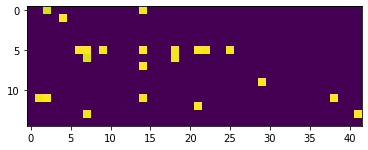


ExtractedWithXY_Cleaned184430_09102019.mat
[ 1  4  6  7 12 13 14 23 24 25 27 29 31 33 36 39]


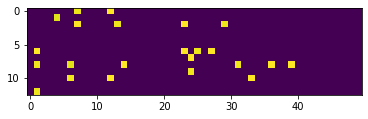


ExtractedWithXY_Cleaned184526_09102019.mat
[ 2  3  4  5  7  8 13 15 17 20 21 23 29 31 35 38 39 42]


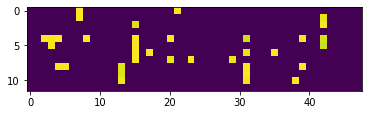


ExtractedWithXY_Cleaned184946_09102019.mat
[ 1  3  5  6 12 15 17 18 19 21 22 26 27 28 30 31 33 35 36 37 38 40 41 44
 46 47 48 49 50 51 52 53 56]


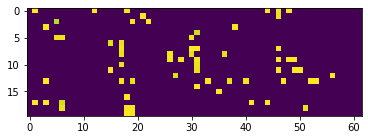


ExtractedWithXY_Cleaned185033_09102019.mat
[ 2  5  7  8 10 11 19 20 22 24 29 31 32 35 42 47 49 50]


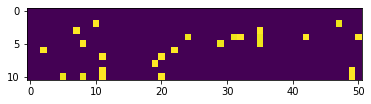


ExtractedWithXY_Cleaned184331_09102019.mat
[ 1  3  6 18 32 36 37 38 40 43]


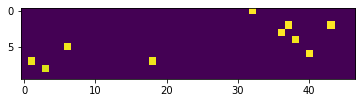


ExtractedWithXY_Cleaned144233_09112019.mat
[ 1  3  5  7  9 14 19 20 22 30 31 32 36 44 45 46 53]


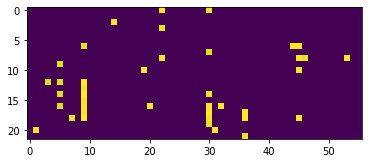


Total Num: 126


In [49]:
total = 0
for key1 in results.keys():
    cache_idx_mat = results[key1]
    neurs = np.argwhere(np.sum(cache_idx_mat, axis=0)>0).squeeze()
    print(key1)
    print(neurs)
#     print("Min: %1.2f"%cache_idx_mat[cache_idx_mat > 0].min())
#     print("Max: %1.2f"%cache_idx_mat.max())
    plt.imshow(cache_idx_mat); plt.show()
    print()
    total += neurs.size
print("Total Num: %d"%total)

## Calculating cache index matrix with agglomerated visits

In [51]:
window = 30
results = {}
for mat_file in mat_files:
    print(mat_file)
    f = h5py.File("data/" + mat_file, 'r')
    wedges = np.array(f['whichWedge']).squeeze()
    cache_sites = np.array(f['CacheSites']).squeeze()
    pokes = np.array(f['CacheFrames']).squeeze().astype(int) - 1
    enters = np.array(f['CacheFramesEnter']).squeeze().astype(int) - 1
    exits = np.array(f['CacheFramesExit']).squeeze().astype(int) - 1
    was_retrieval = np.array(f['ThisWasRetrieval']).squeeze().astype(bool)
    spikes = np.array(f['S'])
    fr = get_fr(spikes)
    cache_idxs = np.zeros((np.unique(cache_sites).size, fr.shape[1]))
    all_cache_frames, all_noncache_frames = get_cache_index_frames(
        wedges, cache_sites, pokes, enters, exits,
        fr, window
        )    
    for idx, cache_site in enumerate(np.unique(cache_sites)):
        cache_frames, _ = get_poke_centered_frames(
            window, wedges,
            cache_site, cache_sites,
            pokes, enters, exits
            )
        noncache_frames = all_noncache_frames[cache_site]
        cache_idx = calc_cache_index(fr, cache_frames, noncache_frames)
        significant = np.zeros(cache_idx.size)
        for _ in range(110):
            shuff_cache_frames, shuff_noncache_frames = shuffle_1darray_lists(
                cache_frames, noncache_frames
                )
            shuff_cache_idx = calc_cache_index(
                fr, shuff_cache_frames, shuff_noncache_frames
                )
            significant += (cache_idx > shuff_cache_idx)
        significant = significant > 0.99*110
        cache_idxs[idx,significant] = cache_idx[significant]        
    results[mat_file] = cache_idxs
with open("cacheidxvisit-30", "wb") as f:
    pickle.dump(results,f)

ExtractedWithXY_Cleaned184713_09102019.mat
ExtractedWithXY_Cleaned184430_09102019.mat
ExtractedWithXY_Cleaned184526_09102019.mat
ExtractedWithXY_Cleaned184946_09102019.mat
ExtractedWithXY_Cleaned185033_09102019.mat
ExtractedWithXY_Cleaned184331_09102019.mat
ExtractedWithXY_Cleaned144233_09112019.mat


ExtractedWithXY_Cleaned184713_09102019.mat
[ 1  2  6  7  9 14 17 18 21 22 25 29 34 37 38]
Min: 0.91
Max: 1.00


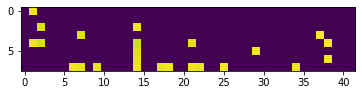


ExtractedWithXY_Cleaned184430_09102019.mat
[ 1  6  7 12 13 14 23 24 27 31 33 39]
Min: 0.89
Max: 1.00


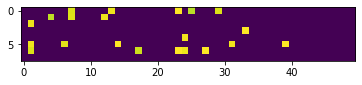


ExtractedWithXY_Cleaned184526_09102019.mat
[ 3  4  7  8 13 15 17 20 21 23 31 35 38 39 42 43]
Min: 0.90
Max: 1.00


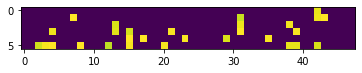


ExtractedWithXY_Cleaned184946_09102019.mat
[ 1  3  5  6 15 17 18 19 21 22 26 27 28 30 31 35 36 37 38 40 41 44 46 47
 48 49 50 52 53 56]
Min: 0.85
Max: 1.00


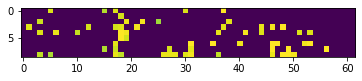


ExtractedWithXY_Cleaned185033_09102019.mat
[ 2  7  8 10 11 18 19 20 21 22 27 31 32 35 40 42 46 47 49 50]
Min: 0.97
Max: 1.00


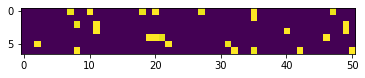


ExtractedWithXY_Cleaned184331_09102019.mat
[ 6 14 18 32 34 36 38 40 43]
Min: 0.92
Max: 1.00


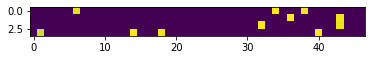


ExtractedWithXY_Cleaned144233_09112019.mat
[ 7  9 11 12 13 14 19 20 22 30 31 32 33 36 44 45 46 53]
Min: 0.81
Max: 1.00


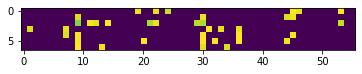


Total Num: 120


In [55]:
total = 0
for key1 in results.keys():
    cache_idx_mat = results[key1]
    neurs = np.argwhere(np.sum(cache_idx_mat, axis=0)>0.95).squeeze()
    print(key1)
    print(neurs)
    print("Min: %1.2f"%cache_idx_mat[cache_idx_mat > 0].min())
    print("Max: %1.2f"%cache_idx_mat.max())
    plt.imshow(cache_idx_mat); plt.show()
    print()
    total += neurs.size
print("Total Num: %d"%total)